MY WORK IN PROGRESS

Potentially use ensemble models, pretrained models, prioritize keras.

In [1]:
# SETUP
# NOTE(liam): '%' targets current kernel.
%pip install numpy pandas scikit-learn keras tensorflow Pillow numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


The following is taken directly from the AJL Starter Notebook:

In [2]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import SparseCategoricalAccuracy
# Explanation:
# - pandas and numpy: for data manipulation
# - sklearn: for splitting data and encoding labels
# - tensorflow.keras: for building and training the neural network

In [3]:
# 2. Load Data
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [4]:
# Check the first few rows to understand the structure
train_df.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,ddi_scale,file_path
0,fd06d13de341cc75ad679916c5d7e6a6.jpg,4,4,prurigo-nodularis,benign-epidermal,benign,NaN,34,prurigo-nodularis/fd06d13de341cc75ad679916c5d7...
1,a4bb4e5206c4e89a303f470576fc5253.jpg,1,1,basal-cell-carcinoma-morpheiform,malignant-epidermal,malignant,NaN,12,basal-cell-carcinoma-morpheiform/a4bb4e5206c4e...
2,c94ce27e389f96bda998e7c3fa5c4a2e.jpg,5,5,keloid,inflammatory,non-neoplastic,1 Diagnostic,56,keloid/c94ce27e389f96bda998e7c3fa5c4a2e.jpg
3,ebcf2b50dd943c700d4e2b586fcd4425.jpg,3,3,basal-cell-carcinoma,malignant-epidermal,malignant,NaN,34,basal-cell-carcinoma/ebcf2b50dd943c700d4e2b586...
4,c77d6c895f05fea73a8f3704307036c0.jpg,1,1,prurigo-nodularis,benign-epidermal,benign,NaN,12,prurigo-nodularis/c77d6c895f05fea73a8f37043070...


In [5]:
# 3. Data Preprocessing
# Encode the labels
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Define image data generators for training and validation
# TODO(liam): upsampling image, augmenting data set, changing color within skintone range
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25, 
    width_shift_range=0.2, height_shift_range=0.2, 
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    zoom_range=[0.8, 1.2],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
    rescale=1./255,                         
)

# Define the directory paths
train_dir = '../data/train/train/'

In [6]:
labelSize = len(train_df['encoded_label'].unique())

In [7]:
def create_generator(dataframe, directory, batch_size=32, target_size=(128, 128)):
    
    # Fill in the correct flow_from_dataframe parameters
    generator = train_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_path',  # Use combined path
        y_col='encoded_label',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=True,
        class_mode='raw',
        validate_filenames=False  # Disable strict filename validation
    )
    return generator

In [8]:
# Create generators
train_generator = create_generator(train_data, train_dir)
val_generator = create_generator(val_data, train_dir)

Found 2288 non-validated image filenames.
Found 572 non-validated image filenames.


In [9]:
base_model = MobileNetV2(
    input_shape=(128,128,3),
    weights='imagenet',
    # classes=len(label_encoder.classes_),
    # classifier_activation='softmax',
    include_top=False
)

base_model.trainable = False

inputs = Input(shape=(128, 128, 3))

cl = Flatten()(base_model.output)
outputs = Dense(len(label_encoder.classes_), activation='softmax')(cl)

model = Model(inputs=base_model.input, outputs=outputs)
model.summary(show_trainable=True)

model.compile(
    optimizer = SGD(learning_rate=1e-4, momentum=0.9), 
    loss = SparseCategoricalCrossentropy(), 
    metrics = ['accuracy']
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Layer (type)          ┃ Output Shape       ┃     Param # ┃ Connected to       ┃ Train… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ input_layer           │ (None, 128, 128,   │           0 │ -                  │   -    │
│ (InputLayer)          │ 3)                 │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ Conv1 (Conv2D)        │ (None, 64, 64, 32) │         864 │ input_layer[0][0]  │   N    │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ bn_Conv1              │ (None, 64, 64, 32) │         128 │ Conv1[0][0]        │   N    │
│ (BatchNormalization)  │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ Conv1_relu (ReLU)     │ (None, 64, 64, 32) │           0 │ bn_Conv1[0][0]     │   -    │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ expanded_conv_depthw… │ (None, 64, 64, 32) │         288 │ Conv1_relu[0][0]   │   N    │
│ (DepthwiseConv2D)     │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ expanded_conv_depthw… │ (None, 64, 64, 32) │         128 │ expanded_conv_dep… │   N    │
│ (BatchNormalization)  │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ expanded_conv_depthw… │ (None, 64, 64, 32) │           0 │ expanded_conv_dep… │   -    │
│ (ReLU)                │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ expanded_conv_project │ (None, 64, 64, 16) │         512 │ expanded_conv_dep… │   N    │
│ (Conv2D)              │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ expanded_conv_projec… │ (None, 64, 64, 16) │          64 │ expanded_conv_pro… │   N    │
│ (BatchNormalization)  │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ block_1_expand        │ (None, 64, 64, 96) │       1,536 │ expanded_conv_pro… │   N    │
│ (Conv2D)              │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ block_1_expand_BN     │ (None, 64, 64, 96) │         384 │ block_1_expand[0]… │   N    │
│ (BatchNormalization)  │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ block_1_expand_relu   │ (None, 64, 64, 96) │           0 │ block_1_expand_BN… │   -    │
│ (ReLU)                │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ block_1_pad           │ (None, 65, 65, 96) │           0 │ block_1_expand_re… │   -    │
│ (ZeroPadding2D)       │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ block_1_depthwise     │ (None, 32, 32, 96) │         864 │ block_1_pad[0][0]  │   N    │
│ (DepthwiseConv2D)     │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ block_1_depthwise_BN  │ (None, 32, 32, 96) │         384 │ block_1_depthwise… │   N  

 Total params: 2,688,085 (10.25 MB)

 Trainable params: 430,101 (1.64 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# hyperparameters
eps = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [11]:
# 5. train the model
# model = model_setup(output_size = labelSize)
hist = model.fit(
    train_generator,
    epochs = eps,
    steps_per_epoch = (train_generator.samples // train_generator.batch_size),
    validation_data = val_generator,
    validation_steps = (val_generator.samples // val_generator.batch_size),
    verbose = 1,
    callbacks = [early_stopping, reduce_lr]
)

C:\Users\scout\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 45s 587ms/step - accuracy: 0.0918 - loss: 3.7080 - val_accuracy: 0.2298 - val_loss: 2.9692 - learning_rate: 1.0000e-04
Epoch 2/100
 1/71 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.1875 - loss: 3.4125

C:\Users\scout\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.1875 - loss: 3.4125 - val_accuracy: 0.2279 - val_loss: 2.9854 - learning_rate: 1.0000e-04
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 557ms/step - accuracy: 0.2264 - loss: 2.8636 - val_accuracy: 0.2794 - val_loss: 2.6925 - learning_rate: 1.0000e-04
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.2812 - loss: 2.4599 - val_accuracy: 0.2886 - val_loss: 2.6728 - learning_rate: 1.0000e-04
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 38s 532ms/step - accuracy: 0.2961 - loss: 2.4887 - val_accuracy: 0.2757 - val_loss: 2.5959 - learning_rate: 1.0000e-04
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.2812 - loss: 2.6295 - val_accuracy: 0.2757 - val_loss: 2.7030 - learning_rate: 1.0000e-04
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 523ms/step - accuracy: 0.2990 - loss: 2.3876 - val_accuracy: 0.3033 - val_loss: 2.4821 - learning_rate: 1.0000e-04
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.

In [12]:
# fine-tune model
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

model.summary(show_trainable=True)

model.compile(
    optimizer = SGD(learning_rate=1e-4, momentum=0.9), 
    loss = SparseCategoricalCrossentropy(), 
    metrics = ['accuracy']
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Layer (type)          ┃ Output Shape       ┃     Param # ┃ Connected to       ┃ Train… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ input_layer           │ (None, 128, 128,   │           0 │ -                  │   -    │
│ (InputLayer)          │ 3)                 │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ Conv1 (Conv2D)        │ (None, 64, 64, 32) │         864 │ input_layer[0][0]  │   N    │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ bn_Conv1              │ (None, 64, 64, 32) │         128 │ Conv1[0][0]        │   N    │
│ (BatchNormalization)  │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ Conv1_relu (ReLU)     │ (None, 64, 64, 32) │           0 │ bn_Conv1[0][0]     │   -    │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ expanded_conv_depthw… │ (None, 64, 64, 32) │         288 │ Conv1_relu[0][0]   │   N    │
│ (DepthwiseConv2D)     │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ expanded_conv_depthw… │ (None, 64, 64, 32) │         128 │ expanded_conv_dep… │   N    │
│ (BatchNormalization)  │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ expanded_conv_depthw… │ (None, 64, 64, 32) │           0 │ expanded_conv_dep… │   -    │
│ (ReLU)                │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ expanded_conv_project │ (None, 64, 64, 16) │         512 │ expanded_conv_dep… │   N    │
│ (Conv2D)              │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ expanded_conv_projec… │ (None, 64, 64, 16) │          64 │ expanded_conv_pro… │   N    │
│ (BatchNormalization)  │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ block_1_expand        │ (None, 64, 64, 96) │       1,536 │ expanded_conv_pro… │   N    │
│ (Conv2D)              │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ block_1_expand_BN     │ (None, 64, 64, 96) │         384 │ block_1_expand[0]… │   N    │
│ (BatchNormalization)  │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ block_1_expand_relu   │ (None, 64, 64, 96) │           0 │ block_1_expand_BN… │   -    │
│ (ReLU)                │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ block_1_pad           │ (None, 65, 65, 96) │           0 │ block_1_expand_re… │   -    │
│ (ZeroPadding2D)       │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ block_1_depthwise     │ (None, 32, 32, 96) │         864 │ block_1_pad[0][0]  │   N    │
│ (DepthwiseConv2D)     │                    │             │                    │        │
├───────────────────────┼────────────────────┼─────────────┼────────────────────┼────────┤
│ block_1_depthwise_BN  │ (None, 32, 32, 96) │         384 │ block_1_depthwise… │   N  

 Total params: 3,118,188 (11.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,688,085 (10.25 MB)

 Optimizer params: 430,103 (1.64 MB)

In [13]:
eps_two = 20

hist_two = model.fit(
    train_generator,
    epochs = eps_two,
    steps_per_epoch = (train_generator.samples // train_generator.batch_size),
    validation_data = val_generator,
    validation_steps = (val_generator.samples // val_generator.batch_size),
    verbose = 1,
    callbacks = [early_stopping, reduce_lr]
)

Epoch 1/20


C:\Users\scout\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 538ms/step - accuracy: 0.3443 - loss: 2.2564 - val_accuracy: 0.2610 - val_loss: 2.5365 - learning_rate: 1.0000e-04
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.2812 - loss: 2.3751 - val_accuracy: 0.2702 - val_loss: 2.5409 - learning_rate: 1.0000e-04
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 524ms/step - accuracy: 0.3253 - loss: 2.2897 - val_accuracy: 0.2868 - val_loss: 2.5674 - learning_rate: 1.0000e-04
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.4688 - loss: 2.0982 - val_accuracy: 0.2941 - val_loss: 2.4658 - learning_rate: 1.0000e-04
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 543ms/step - accuracy: 0.3388 - loss: 2.2349 - val_accuracy: 0.2868 - val_loss: 2.6018 - learning_rate: 1.0000e-04
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.3750 - loss: 2.3411 - val_accuracy: 0.2960 - val_loss: 2.5331 - learning_rate: 1.0000e-04
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 545ms/step - accuracy: 0.3492 

In [14]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

ValueError: x and y must have same first dimension, but have shapes (27,) and (12,)

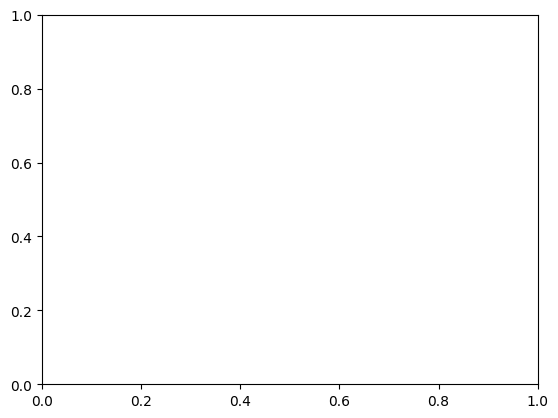

In [15]:
plotLearningCurve(hist, 27)

In [ ]:
plotLearningCurve(hist_two, 7)

In [ ]:
y_true = val_generator.labels

y_pred = model.predict(val_generator)
y_pred_classes = y_pred.argmax(axis=1)

f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("Weighted F1 Score: ", f1)

In [ ]:
# 6. Make Predictions on Test Data
def preprocess_test_data(test_df, directory, target_size=(128, 128), batch_size=32):
    """
    Template for loading and preprocessing test images.
    """
    # TODO: create a generator for the test set here.
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=directory,
        x_col='md5hash',
        #y_col=None,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        validate_filenames=False
    )
    return test_generator

In [ ]:
# Load test data
test_dir = '../data/test/test/'
test_generator = preprocess_test_data(test_df, test_dir)

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
# assigns numbered labels to its named version
test_df['label'] = label_encoder.inverse_transform((predicted_classes))

In [ ]:
model.save('mnet-skin.keras')

In [ ]:
# 7. generate predictions
# Generate predictions based on the trained model
# Then, save the predictions into a CSV file for submission
final = test_df[['md5hash', 'label']]
final.to_csv('submission.csv', index=False)

print("Submission file created successfully!")